<a href="https://colab.research.google.com/github/JunHL96/PyTorch-Course/blob/main/04_pytorch_custom_datasets_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/drive/1LH4HinVwLGL-gYXot2zkoCIdxtMMI5N_" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/JunHL96/PyTorch-Course/blob/main/04_pytorch_custom_datasets_notes.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/04_pytorch_custom_datasets.pdf) | [Watch Video Walkthrough](https://youtu.be/Z_ikDlimN6A?t=71010)

# 04. PyTorch Custom Datasets



In the last notebook, [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/), we looked at how to build computer vision models on an in-built dataset in PyTorch (FashionMNIST).

The steps we took are similar across many different problems in machine learning.

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own **custom dataset**.

## What is a custom dataset?



A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

## What we're going to cover



We're going to be applying the PyTorch Workflow we covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) and [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

## 0. Importing PyTorch and setting up device-agnostic code

In [19]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.1+cu121'

And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [20]:
# Device-Agnostic Code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121


## 1. Acquire Data

To begin, we need a dataset. Fortunately, some data has already been prepared for us.

We'll start with a small subset because our goal isn't to train the largest model or use the biggest dataset initially. Machine learning is an iterative process: start small, achieve functionality, then scale up as needed.

We will use a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). Food101 is a well-known computer vision benchmark containing 101,000 images of 101 different food categories (75,750 for training and 25,250 for testing).

Instead of working with all 101 food classes, we'll focus on three: pizza, steak, and sushi. Additionally, we'll use a random 10% of the images per class to keep the dataset manageable.

If you're interested in the data sources, refer to the following resources:
* [Original Food101 Dataset and Paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - The version used in this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - Notebook used to format the Food101 dataset for this project.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - Zip archive containing the selected images.

Next, we'll write code to download the formatted data from GitHub.

> **Note:** While the dataset we're using has been pre-formatted for our purposes, you will often need to format your own datasets to suit your specific problems. This is a common practice in the machine learning field.

In [21]:
import requests  # Import the requests library to handle HTTP requests
import zipfile   # Import the zipfile module to work with ZIP archives
from pathlib import Path  # Import Path from pathlib for easy path manipulations

# Setup path to data folder
data_path = Path("data/")  # Define the base data directory
image_path = data_path / "pizza_steak_sushi"  # Define the path for the specific image dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir(): # is_dir will return True if the directory exists
    print(f"{image_path} directory exists.")  # Inform the user that the directory already exists
else:
    print(f"Did not find {image_path} directory, creating one...")  # Inform the user that the directory is missing
    image_path.mkdir(parents=True, exist_ok=True)  # Create the directory, including any necessary parent directories

    # Download pizza, steak, sushi data
    # by using "with" here, the file will automatically close after the block of code is executed.
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f: # wb means "write binary", f is for "file"
        # Send a GET request to download the ZIP file containing the dataset
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") # the url where file is located
        print("Downloading pizza, steak, sushi data...")  # Notify the user that the download has started
        f.write(request.content)  # Write the downloaded content to the ZIP file

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")  # Notify the user that extraction has started
        zip_ref.extractall(image_path)  # Extract all contents of the ZIP file into the image_path directory

data/pizza_steak_sushi directory exists.


#### **Data Preparation for Custom Datasets in PyTorch**



##### Overview

The provided script is designed to download and unzip a dataset containing images of pizza, steak, and sushi. This dataset is essential for training custom models using PyTorch, especially when dealing with image classification tasks. The script ensures that the necessary data is available locally, making it easier to proceed with model development.

##### Key Components of the Script

1. **Importing Libraries**
   ```python
   import requests  # Import the requests library to handle HTTP requests
   import zipfile   # Import the zipfile module to work with ZIP archives
   from pathlib import Path  # Import Path from pathlib for easy path manipulations
   ```
   - `requests`: A popular Python library used to send HTTP requests. It simplifies the process of downloading files from the internet.
   - `zipfile`: A built-in Python module that provides tools to create, read, write, append, and list a ZIP file. This is useful for handling compressed datasets.
   - `pathlib.Path`: Part of the `pathlib` module, which offers an object-oriented approach to handle filesystem paths. It makes path manipulations more intuitive and readable.

2. **Setting Up Data Paths**
   ```python
   data_path = Path("data/")  # Define the base data directory
   image_path = data_path / "pizza_steak_sushi"  # Define the path for the specific image dataset
   ```
   - `Path("data/")`: Creates a `Path` object representing the base directory where all data will be stored.
   - `image_path = data_path / "pizza_steak_sushi"`: Uses the `/` operator to concatenate paths, creating a subdirectory specifically for the pizza, steak, and sushi images.

3. **Checking Directory Existence**
   ```python
   if image_path.is_dir():  # is_dir will return True if the directory exists
       print(f"{image_path} directory exists.")  # Inform the user that the directory already exists
   else:
       print(f"Did not find {image_path} directory, creating one...")  # Inform the user that the directory is missing
       image_path.mkdir(parents=True, exist_ok=True)  # Create the directory, including any necessary parent directories
   ```
   - `is_dir()`: A method of the `Path` object that checks if the specified path exists and is a directory.
   - `mkdir(parents=True, exist_ok=True)`: Creates the directory along with any necessary parent directories. The parameter `parents=True` ensures that all intermediate-level directories needed to contain the leaf directory are also created. The parameter `exist_ok=True` prevents an error from being raised if the directory already exists.

4. **Downloading Dataset**
   ```python
   with open(data_path / "pizza_steak_sushi.zip", "wb") as f:  # wb means "write binary", f is for "file"
       request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
       print("Downloading pizza, steak, sushi data...")
       f.write(request.content)
   ```
   - `with open(data_path / "pizza_steak_sushi.zip", "wb") as f`: Opens a file in write-binary mode (`"wb"`). This is necessary because the content being written is binary (a ZIP file).
   - `requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")`: Sends an HTTP GET request to the specified URL and retrieves the dataset as a response object.
   - `request.content`: Accesses the raw bytes of the response payload, which is the content of the ZIP file.
   - `f.write(request.content)`: Writes the binary content to the file, effectively saving the downloaded ZIP file locally.

5. **Unzipping Dataset**
   ```python
   with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
       print("Unzipping pizza, steak, sushi data...")
       zip_ref.extractall(image_path)
   ```
   - `zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r")`: Opens the ZIP file in read mode (`"r"`).
   - `extractall(image_path)`: Extracts all files and directories from the ZIP archive into the specified directory (`image_path`).

##### Documentation Links

- [Requests Library](https://docs.python-requests.org/en/master/): Official documentation for the requests library, which is used to send HTTP requests and download files.
- [Zipfile Module](https://docs.python.org/3/library/zipfile.html): Python standard library documentation for working with ZIP files, including creating, reading, writing, appending, and listing ZIP archives.
- [Pathlib Module](https://docs.python.org/3/library/pathlib.html): Python standard library documentation for handling filesystem paths in an object-oriented way, making path manipulations more intuitive and readable.

##### Additional Resources

- [PyTorch Custom Datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#custom-datasets): Official PyTorch tutorial on creating custom datasets, which is useful after preparing the dataset with this script.
- [Pathlib Documentation](https://docs.python.org/3/library/pathlib.html): Comprehensive guide to using `pathlib` for filesystem path manipulations.

This script sets up the necessary environment to work with a custom dataset in PyTorch, ensuring that all images are downloaded and ready for processing. By following these steps, you can easily integrate this dataset into your machine learning workflows.

## 2. Understand the Data (Data Preparation)



With the dataset downloaded, the next crucial step is to familiarize ourselves with it. This process, often called *data preparation*, is essential before building a machine learning model.

As Abraham Lossfunction said...

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="tweet by mrdbourke, if I had eight hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset" width=800/>

Data preparation involves deeply understanding the dataset and its structure. Before diving into model development, it's vital to ask:  **What am I trying to do with this data?**



### Dataset Overview



Our dataset consists of images of pizza, steak, and sushi, organized in a standard *image classification format*. This format is widely used in image classification benchmarks, including datasets like [ImageNet](https://www.image-net.org/). In this format:
- Each image class has its own directory, named after the class (e.g., `pizza/`, `steak/`, `sushi/`).
- These directories are further divided into training (`train/`) and testing (`test/`) subsets.


This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.

```
pizza_steak_sushi/                  # Overall dataset folder
├── train/                          # Training images
│   ├── pizza/                      # Class: Pizza
│   │   ├── image01.jpeg
│   │   ├── image02.jpeg
│   │   └── ...
│   ├── steak/                      # Class: Steak
│   │   ├── image24.jpeg
│   │   ├── image25.jpeg
│   │   └── ...
│   └── sushi/                      # Class: Sushi
│       ├── image37.jpeg
│       └── ...
└── test/                           # Testing images
    ├── pizza/                      # Class: Pizza
    │   ├── image101.jpeg
    │   ├── image102.jpeg
    │   └── ...
    ├── steak/                      # Class: Steak
    │   ├── image154.jpeg
    │   ├── image155.jpeg
    │   └── ...
    └── sushi/                      # Class: Sushi
        ├── image167.jpeg
        └── ...
```



### Objective



The goal is to:
1. Analyze the dataset's structure to ensure it meets the requirements for training a machine learning model.
2. Convert this structure into a format usable with PyTorch.



### Key Concepts



1. **Data Inspection**:
   - Carefully review the dataset's contents.
   - Ensure the images and their classifications are correctly organized.
   - This helps you understand what you're working with and spot any potential issues.

2. **Data Storage Format**:
   - The dataset follows a hierarchical folder structure with class names as folder names.
   - Separate training and testing sets help in evaluating model performance.

3. **Data Preparation**:
   - Adapt the existing data format to be compatible with the tools you plan to use (e.g., PyTorch).
   - Ensure the dataset is cleaned and properly structured for optimal model training.



### Why This Matters



The structure and quality of your data directly impact the performance of your machine learning model. A well-prepared dataset minimizes errors, reduces preprocessing overhead, and helps your model learn effectively.

> **Note:** Data preparation varies depending on the problem you're solving, but the core principle remains the same: understand your data thoroughly, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk).

### `walk_through_dir` Function

In [22]:
import os  # Module for interacting with the operating system, including file and directory operations

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents

    Args:
        dir_path (str or pathlib.Path): Target directory to walk through.

    Returns:
        Prints out:
            - Number of subdirectories in dir_path
            - Number of images (files) in each subdirectory
            - Name of each subdirectory
    """
    # for: path to current directory, list of subdirectories in current directory, list of files in current directory
    for dirpath, dirnames, filenames in os.walk(dir_path):
        # Output the count of subdirectories and image files in the current directory
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Invoke the function to traverse and display contents of image_path directory
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


Excellent!

It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started.

Remember, these images are subsets of the original Food101 dataset.

You can see how they were created in the [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

While we're at it, let's setup our training and testing paths.

In [23]:
# Setup train and testing paths
train_dir = image_path / "train"  # Define the path for the training dataset by appending "train" to the base image_path
test_dir = image_path / "test"    # Define the path for the testing dataset by appending "test" to the base image_path

train_dir, test_dir  # Output the train and test directory paths

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image



Okay, we've seen how our directory structure is formatted.

Now in the spirit of the data explorer, it's time to *visualize, visualize, visualize!*

Let's write some code to:
1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`.
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/train/pizza/2785084.jpg
Image class: pizza
Image height: 366
Image width: 512


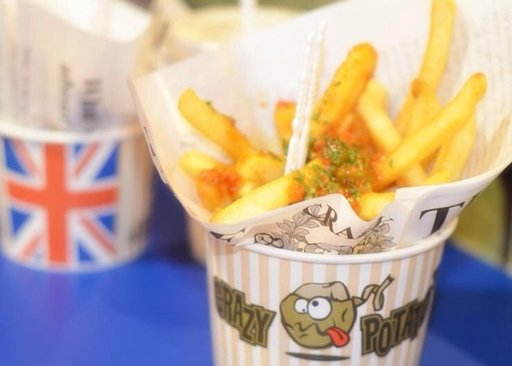

In [24]:
import random  # Import the random module for generating random numbers and making random selections
from PIL import Image  # Import the Image class from the Pillow library
# PIL provides a powerful set of tools for working with images, including opening, manipulating, and saving them.

# Set seed for reproducibility
random.seed(42)  # Setting the seed ensures that the random selections are the same every time the code is run


# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
# Use the glob method from pathlib.Path to find all JPEG images in any subdirectory two levels deep using */*/*.jpg
# For example, it will match paths like "train/pizza/pizza1.jpg" or "test/steak/steak2.jpg"
# Convert the generator returned by glob into a list for easy access
# if you don't convert the generator to a list, you can only iterate over it once, so random.choice() won't work again after the first iteration

# 2. Get random image path
random_image_path = random.choice(image_path_list)  # Select a random image path from the list for random sampling of images from the dataset


# 3. Get image class from path name
image_class = random_image_path.parent.stem     # Access the parent directory of the image file and get its name (stem) without the file extension
# For example, if the path is "train/pizza/pizza1.jpg", the class is "pizza"

# 4. Open image
img = Image.open(random_image_path)     # Open the image file using Pillow's Image class which provides further processing or analysis of the image

# 5. Print metadata using PIL library
print(f"Random image path: {random_image_path}")    # Display the full path of the randomly selected image

print(f"Image class: {image_class}")    # Display the class/category of the image (e.g., pizza, steak, sushi)

print(f"Image height: {img.height}")    # Display the height of the image in pixels

print(f"Image width: {img.width}")  # Display the width of the image in pixels

img
# In Jupyter notebooks, placing the image object at the end will render and display the image

# image_path_list # uncomment this line if you want to see image paths


#### Explanation of Visualizing an Image



##### 1. Import Modules
```python
import random
from PIL import Image
```
- `random`: This module is used for generating random numbers and making random selections.
- `Image` from `PIL`: The Pillow library (PIL) provides extensive file format support, an efficient internal representation, and fairly powerful image processing capabilities.

##### 2. Set Seed for Reproducibility
```python
random.seed(42)
```
- Setting the seed ensures that the random selections are the same every time the code is run. This is useful for debugging and ensuring consistent results.

##### 3. Get All Image Paths
```python
image_path_list = list(image_path.glob("*/*/*.jpg"))
```
- `image_path.glob("*/*/*.jpg")`: The `glob` method from `pathlib.Path` is used to find all JPEG images in any subdirectory two levels deep. For example, it will match paths like `"train/pizza/pizza1.jpg"` or `"test/steak/steak2.jpg"`.
- `list(...)`: The generator returned by `glob` is converted into a list for easy access. If you don't convert the generator to a list, you can only iterate over it once, so `random.choice()` won't work again after the first iteration.

##### 4. Get Random Image Path
```python
random_image_path = random.choice(image_path_list)
```
- `random.choice(image_path_list)`: Selects a random image path from the list for random sampling of images from the dataset.

##### 5. Get Image Class from Path Name
```python
image_class = random_image_path.parent.stem
```
- `random_image_path.parent.stem`: Accesses the parent directory of the image file and gets its name (stem) without the file extension. For example, if the path is `"train/pizza/pizza1.jpg"`, the class is `"pizza"`.

##### 6. Open Image
```python
img = Image.open(random_image_path)
```
- `Image.open(random_image_path)`: Opens the image file using Pillow's `Image` class, which provides further processing or analysis of the image.

##### 7. Print Metadata Using PIL Library
```python
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
```
- `print(...)`: Displays the full path of the randomly selected image, the class/category of the image (e.g., pizza, steak, sushi), and the dimensions of the image in pixels.

##### 8. Display Image
```python
img
```
- In Jupyter notebooks, placing the image object at the end will render and display the image.



We can do the same with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

(-0.5, 511.5, 365.5, -0.5)

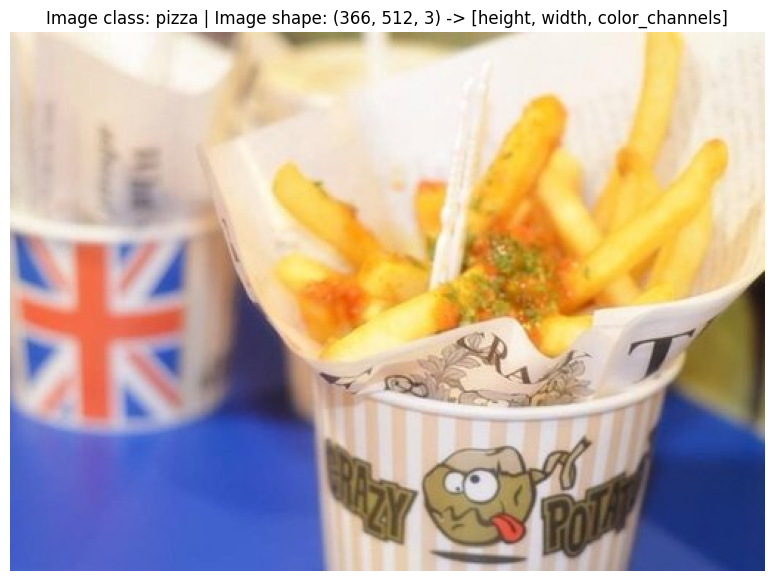

In [25]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting images

# Turn the image into a NumPy array
img_as_array = np.asarray(img)

# Plot the image using matplotlib
plt.figure(figsize=(10, 7))  # Set the figure size
plt.imshow(img_as_array)  # Display the image array
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
# Set the plot title with image class and shape details
plt.axis(False)  # Hide the axis for a cleaner look

## 3. Transforming data



Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on.

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

Let's import some base libraries.

In [26]:
import torch
from torch.utils.data import DataLoader  # DataLoader will help us to load the data in batches
from torchvision import datasets, transforms    # datasets is for pre-defined datasets, transforms is for image transformations

### 3.1 Transforming data with `torchvision.transforms`



We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data. In other words, this artificially increases the diversity of our dataset).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [27]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64 in order to be of uniform size for our model input
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

#data_transform(img) # uncomment this to output tensors
data_transform(img).shape # uncomment this to output tensor shape


torch.Size([3, 64, 64])

#### Code Explanation





##### 64x64
- **Reason for 64x64**: Resizing images to 64x64 pixels standardizes the input size, which is essential for training neural networks. This size is a balance between maintaining sufficient detail for the model to learn meaningful features and reducing computational complexity. While 64x64 is somewhat arbitrary, it is commonly used for smaller-scale projects and experiments. Depending on the specific application and dataset, different sizes (e.g., 32x32, 128x128) might be more appropriate.

##### transforms

- **Description**: `transforms` is a module from the `torchvision` library that provides a suite of tools for preprocessing and augmenting image data. It allows you to compose several image transformations into a single pipeline, which can be applied to datasets to prepare them for training neural networks.
- **Usage**: By using `transforms.Compose`, multiple transformations can be chained together to be applied sequentially to each image in the dataset.

##### Resize

- **Function**: `transforms.Resize(size=(64, 64))`
- **Purpose**: Resizes the input image to the specified dimensions (64x64 pixels in this case).
- **Why It's Important**:
  - **Uniformity**: Ensures all images have the same dimensions, which is required for batch processing in neural networks.
  - **Computational Efficiency**: Smaller image sizes reduce the amount of data the model needs to process, speeding up training and inference.
- **Considerations**: Choosing the right size depends on the complexity of the task and the available computational resources. Larger sizes retain more detail but require more processing power.

##### RandomHorizontalFlip

- **Function**: `transforms.RandomHorizontalFlip(p=0.5)`
- **Purpose**: Randomly flips the image horizontally with a probability of 50%.
- **Benefits**:
  - **Data Augmentation**: Introduces variability in the training data, which helps the model generalize better to unseen data.
  - **Robustness**: Makes the model invariant to horizontal orientations of objects, improving its ability to recognize objects regardless of their horizontal placement.
- **Parameters**:
  - `p=0.5`: Sets the probability of flipping an image. A value of 0.5 means there's an equal chance for the image to be flipped or left as is.

##### ToTensor

- **Function**: `transforms.ToTensor()`
- **Purpose**: Converts a PIL Image or NumPy `ndarray` into a PyTorch tensor.
- **Key Actions**:
  - **Scaling**: Transforms pixel values from the range [0, 255] to [0.0, 1.0], which is a common preprocessing step for neural networks.
  - **Dimension Adjustment**: Changes the image shape from (H, W, C) to (C, H, W), as PyTorch expects the channel dimension first.
- **Importance**:
  - **Compatibility**: Prepares image data in a format that PyTorch models can process.
  - **Normalization**: Helps in stabilizing and accelerating the training process by ensuring consistent input scales.


Now we've got a composition of transforms, let's write a function to try them out on various images.

### 3.2 `plot_transformed_images` Function

In the previous section, we applied transformations to a single image. In this section, we will extend this approach to transform multiple images simultaneously.

Transforms play a crucial role in preparing your images for model training and performing data augmentation. By applying a series of transformations to batches of images, we can enhance the diversity of our dataset, improve model generalization, and reduce overfitting.

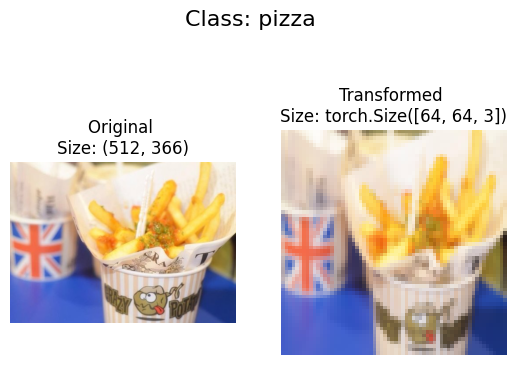

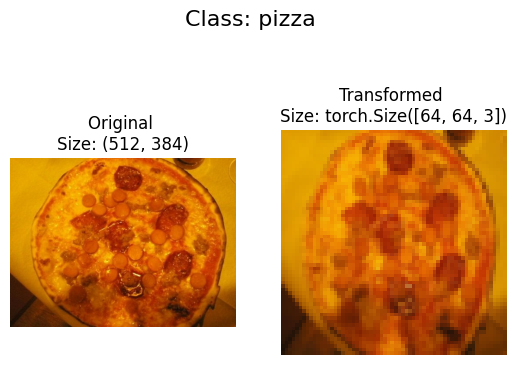

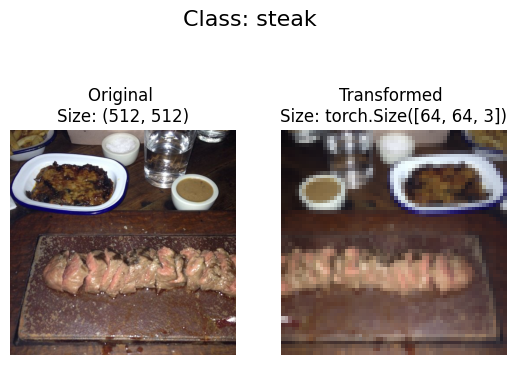

In [28]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)                                       # Set the random seed for reproducibility
    random_image_paths = random.sample(image_paths, k=n)    # Select n random image paths from the list
    for image_path in random_image_paths:                   # Iterate over each image path in the list of 'n' random images
        with Image.open(image_path) as f:                   # Open the image file
            fig, ax = plt.subplots(1, 2)                    # Create a figure with two subplots side by side
            ax[0].imshow(f)                                 # Display the original image in the first subplot
            ax[0].set_title(f"Original \nSize: {f.size}")   # Set the title for the original image subplot
            ax[0].axis("off")                               # Hide the axes for the original image subplot

            # Transform and plot image (original and transformed will be side-by-side)
            # Note: permute() will change shape of image to suit matplotlib

            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)                    # Apply transformations and rearrange dimensions for plotting
            ax[1].imshow(transformed_image)                                      # Display the transformed image in the second subplot
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")    # Set the title for the transformed image subplot
            ax[1].axis("off")                                                    # Hide the axes for the transformed image subplot

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)        # Set the overall title for the figure indicating the image class

plot_transformed_images(         # Plot the transformation
    image_path_list,             # Provide the list of image paths to the function
    transform=data_transform,    # Specify the transformation to apply to images
    n=3                          # Define the number of images
)                                # Call the function to execute the plotting

#### **Explanation of `plot_transformed_images` Function**



The provided code snippet defines a function called `plot_transformed_images`. This function is designed to plot a series of random images from a given list of image paths, apply specified transformations to these images, and display both the original and transformed images side by side. Here's a detailed breakdown:

##### 1. Function Definition
```python
def plot_transformed_images(image_paths, transform, n=3, seed=42):
```
- **Parameters**:
  - `image_paths (list)`: A list of file paths to the target images.
  - `transform (PyTorch Transforms)`: The transformations to apply to the images.
  - `n (int, optional)`: The number of images to plot. Defaults to 3.
  - `seed (int, optional)`: The random seed for reproducibility. Defaults to 42.

##### 2. Set Random Seed
```python
random.seed(seed)
```
- Ensures that the random selections are consistent across different runs by setting a fixed seed value.

##### 3. Select Random Image Paths
```python
random_image_paths = random.sample(image_paths, k=n)
```
- Uses `random.sample` to select `n` unique image paths from the provided list of image paths.

##### 4. Iterate Over Selected Image Paths
```python
for image_path in random_image_paths:
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")
```
- Opens each selected image file using `Image.open`.
- Creates a figure with two subplots side by side.
- Displays the original image in the first subplot and sets its title to include the image size.
- Hides the axes for better visualization.

##### 5. Apply Transformations and Plot Transformed Image
```python
transformed_image = transform(f).permute(1, 2, 0)
ax[1].imshow(transformed_image)
ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
ax[1].axis("off")
```
- Applies the specified transformations to the image using `transform(f)`.
- Rearranges the dimensions of the transformed image from `[C, H, W]` (PyTorch default) to `[H, W, C]` (Matplotlib format) using `.permute(1, 2, 0)`.
- Displays the transformed image in the second subplot and sets its title to include the new shape.
- Hides the axes for better visualization.

##### 6. Set Overall Title
```python
fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
```
- Sets an overall title for the figure indicating the class of the image, derived from the parent directory name.


The function is then called with the following parameters:
```python
plot_transformed_images(
    image_path_list,
    transform=data_transform,
    n=3
)
```
- `image_path_list`: The list of image paths to be used.
- `transform=data_transform`: The transformation pipeline to apply to each image.
- `n=3`: Specifies that 3 images should be plotted.



Nice!

We've now got a way to convert our images to tensors using `torchvision.transforms`.

We also manipulate their size and orientation if needed (some models prefer images of different sizes and shapes).

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size `[256, 256, 3]` will have 16x more pixels than an image of size `[64, 64, 3]` (`(256*256*3)/(64*64*3)=16`).

However, the tradeoff is that more pixels requires more computations.

> **Exercise:** Try commenting out one of the transforms in `data_transform` and running the plotting function `plot_transformed_images()` again, what happens?

## 4. Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)



Alright, time to turn our image data into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing in `transform=data_transform` to turn our images into tensors.

In [29]:
# Import the 'datasets' module from 'torchvision', which provides easy access to various image datasets
from torchvision import datasets

# Create a training dataset using ImageFolder
train_data = datasets.ImageFolder(root=train_dir,                # Specify the path to the root directory containing training images
                                                                 # The directory should have subdirectories for each class, each containing respective images
                                  transform=data_transform,      # Define a series of transformations to apply to the images
                                                                 # This can include resizing, normalization, data augmentation, etc.
                                  target_transform=None)         # (Optional) Define a transformation for the labels/target
                                                                 # For example, converting class names to integer labels
                                                                 # Set to 'None' if no transformation is needed.

test_data = datasets.ImageFolder(root=test_dir,                  # Specify the path to the root directory containing testing images
                                 transform=data_transform)       # Define a series of transformations to apply to the images)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

#### **`ImageFolder` Functionality**




In machine learning and deep learning, having a well-structured dataset is crucial for training models effectively. PyTorch, a popular open-source library for deep learning, provides several utilities to handle datasets easily. One such utility is the `datasets` module from `torchvision`, which simplifies the process of loading and transforming image datasets.

##### 1. Importing the Datasets Module

```python
from torchvision import datasets
```

- The first step is to import the `datasets` module from `torchvision`. This module provides a variety of pre-loaded datasets, such as ImageNet, CIFAR-10, MNIST, etc., and also allows for easy creation of custom datasets using classes like `ImageFolder`.

##### 2. Creating a Training Dataset Using ImageFolder

```python
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
```

- Here, we are creating a training dataset using the `ImageFolder` class. This class is particularly useful for image classification tasks where images are organized into subdirectories named after their respective classes.

###### Parameters

- **root**:
  - Specifies the path to the root directory containing the training images.
  - The directory structure should be such that each subdirectory corresponds to a different class, and within each subdirectory, there are images belonging to that class. For example:
    ```
    train_dir/
        class1/
            img001.jpg
            img002.jpg
            ...
        class2/
            img001.jpg
            img002.jpg
            ...
        ...
    ```

- **transform**:
  - This parameter accepts a series of transformations to apply to the images before they are fed into the model.
  - These transformations can include resizing, cropping, flipping, normalization, and other forms of data augmentation. They help in improving the generalization of the model by exposing it to more varied inputs during training.
  - Example transformation pipeline using `torchvision.transforms`:
    ```python
    import torchvision.transforms as transforms

    data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    ```

- **target_transform**:
  - This parameter is optional and allows for transformations to be applied to the labels or target values.
  - For example, if you need to convert class names into integer labels, this would be where you define that transformation.
  - If no specific transformation is needed for the targets, it can be set to `None` (as shown in the code snippet).

By using `ImageFolder`, PyTorch automatically loads images from the specified directory structure and applies the given transformations. This makes the process of preparing datasets more efficient and less error-prone, enabling researchers and developers to focus more on model development and experimentation rather than dataset management.

##### 3. Creating a Testing Dataset Using ImageFolder

```python
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
```

Similarly, we create a testing dataset using the `ImageFolder` class. The structure and parameters are very similar to those used for the training dataset.

###### Parameters

- **root**:
  - Specifies the path to the root directory containing the testing images.
  - Similar to the training dataset, the directory should have subdirectories for each class, each containing respective images. For example:
    ```
    test_dir/
        class1/
            img001.jpg
            img002.jpg
            ...
        class2/
            img001.jpg
            img002.jpg
            ...
        ...
    ```

- **transform**:
  - This parameter accepts the same series of transformations applied to the images as in the training dataset.
  - It ensures that the testing images undergo the same preprocessing steps, maintaining consistency between the training and testing datasets.

##### 4. Why Don't We Specify `target_transform` for Test Data?

The decision not to specify a `target_transform` for the test data is based on several considerations:

1. **Consistency**:
   - During training, the model learns to map input images to specific class labels. The same mapping should be used during testing to ensure that the model's performance is evaluated consistently.
   - If different transformations are applied to the target labels in the test dataset, it could lead to discrepancies and make it difficult to interpret the results accurately.

2. **Simplicity**:
   - By not specifying a `target_transform` for the test data, we maintain simplicity and avoid potential errors that might arise from applying inconsistent transformations.
   - The default behavior of `ImageFolder` is to convert class names into integer labels based on the directory structure, which is consistent with how the training dataset is handled.

3. **Standardization**:
   - In many cases, the target labels are already in a standardized format (e.g., integer labels) that does not require additional transformation.
   - If any specific transformation is needed for the target labels, it should be applied consistently to both the training and testing datasets to ensure fairness and accuracy in evaluation.

4. **Best Practices**:
   - Best practices in machine learning emphasize the importance of consistency between training and testing datasets.
   - By not specifying a `target_transform` for the test data, we adhere to these best practices, ensuring that the model is evaluated under the same conditions it was trained on.

##### 5. Summary

- **Importing**: Start by importing the `datasets` module from `torchvision`.
- **ImageFolder**: Utilize this class for image classification tasks where images are organized into subdirectories named after their classes.
- **Parameters**:
  - **root**: Path to the root directory containing training or testing images.
  - **transform**: Series of transformations applied to the images.
  - **target_transform**: Optional transformations applied to the labels/targets.

This setup provides a flexible and efficient way to handle image datasets in PyTorch, facilitating both research and production use cases. The code snippet demonstrates how to create both training and testing datasets using `ImageFolder`, ensuring that the same preprocessing steps are applied consistently across both datasets.

```python
train_data, test_data
```

This final line returns the created `train_data` and `test_data` objects, which can be used for further processing, such as loading data into dataloaders or training a model.

By not specifying a `target_transform` for the test data, we ensure consistency and maintain best practices in dataset handling, leading to more reliable and interpretable evaluation of the model's performance.

#### **Inspect the Datasets**



It looks like PyTorch has registered our `Dataset`'s.

Let's inspect them by checking out the `classes` and `class_to_idx` attributes as well as the lengths of our training and test sets.

##### 1. `.classes` Attribute

- The `.classes` attribute from the `ImageFolder` class provides a list of class names in the dataset. Here is how you can access it:

```python
class_names = train_data.classes  # .classes is from ImageFolder and provides the class names in the dataset
class_names
```

##### 2. `.class_to_idx` Attribute

- The `.class_to_idx` attribute from the `ImageFolder` class provides a dictionary mapping each class name to its respective index. Here is how you can access it:

```python
# Get class names as a dictionary
class_dict = train_data.class_to_idx  # .class_to_idx is from ImageFolder and provides the class names and their respective indices
class_dict
```

For more information, you can refer to the [PyTorch `ImageFolder` documentation](https://pytorch.org/vision/stable/datasets.html#imagefolder).

#### **class_names and class_dict**

In [30]:
class_names = train_data.classes  # .classes is from ImageFolder and provides the class names in the dataset
class_names

['pizza', 'steak', 'sushi']

In [31]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx  # .class_to_idx is from ImageFolder and provides the class names and their respective indices
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [32]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

Nice! Looks like we'll be able to use these to reference for later.

How about our images and labels?

How do they look?

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [33]:
# Index on the train_data Dataset to get a single image and its label
img, label = train_data[0][0], train_data[0][1]  # Get the first image and its label from the training dataset
print(f"Image tensor:\n{img}")  # Display the image tensor
print(f"Image label: {label}")   # Display the image label
print(f"Image datatype: {img.dtype}")  # Display the image datatype
print(f"Image label: {label}")  # Display the image label
print(f"Label datatype: {type(label)}")  # Display the datatype of the label

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

#### **Inspecting a Single Image and Label from the Dataset**



In this section, we will inspect a single image and its corresponding label from the training dataset to understand their structure and data types.

##### 1. Accessing an Image and Its Label

- We use indexing on the `train_data` dataset to retrieve the first image and its label. The `ImageFolder` class allows us to access individual samples using this method.

```python
img, label = train_data[0][0], train_data[0][1]  # Get the first image and its label from the training dataset
```

##### 2. Displaying the Image Tensor

- We print the image tensor to understand its structure. The image is represented as a PyTorch tensor.

```python
print(f"Image tensor:\n{img}")  # Display the image tensor
```

##### 3. Displaying the Image Label

- We print the label associated with the image to see what it represents.

```python
print(f"Image label: {label}")   # Display the image label
```

##### 4. Displaying the Image Datatype

- We check the datatype of the image tensor to ensure it is in the expected format, typically `torch.FloatTensor` for images.

```python
print(f"Image datatype: {img.dtype}")  # Display the image datatype
```

##### 5. Displaying the Label Datatype

- We also check the datatype of the label to confirm its type, which is usually an integer (`int`) representing the class index.

```python
print(f"Label datatype: {type(label)}")  # Display the datatype of the label
```

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Post-permutation shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

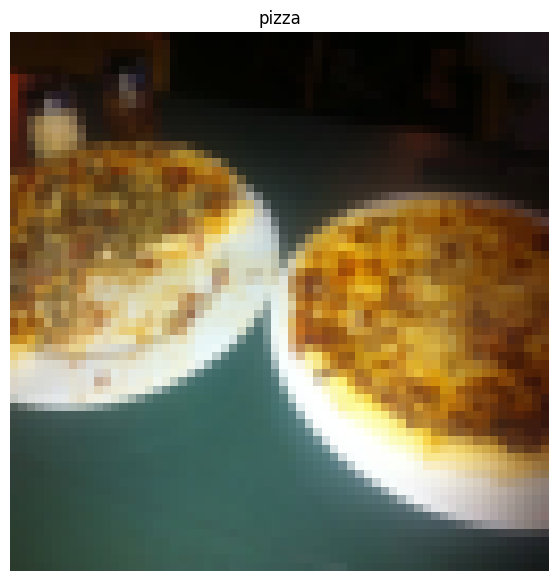

In [34]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)  # Rearrange the dimensions of the image tensor for plotting

# Print out different shapes
print(f"Original image shape: {img.shape} -> [color_channels, height, width]")  # Display the original shape of the image tensor
print(f"Post-permutation shape: {img_permute.shape} -> [height, width, color_channels]")  # Display the shape of the permuted image

# Plot the image
plt.figure(figsize=(10, 7))  # Set the figure size
plt.imshow(img_permute)      # Display the image tensor
plt.axis("off")              # Hide the axis
plt.title(class_names[label])  # Set the title of the plot to the class name of the image

Notice the image is now more pixelated (less quality).

This is due to it being resized from `512x512` to `64x64` pixels.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

### **4.1 Turn loaded images (Datasets) into `DataLoader`'s**




Now that we have our images as PyTorch `Dataset` objects, let's convert them into `DataLoader` objects using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

#### What is DataLoader and why use it?

- Converting `Dataset` objects to `DataLoader` objects makes them iterable. This allows a model to go through and learn the relationships between samples and targets (features and labels).
- `DataLoader` handles batching, shuffling, and loading data in parallel using multiple subprocesses.

#### Setting Up DataLoader

We'll use a simple configuration with:
- `batch_size=1`: Each batch will contain one sample.
- `num_workers=1`: One subprocess will be used to load the data.

#### What is `num_workers`?

- `num_workers` defines how many subprocesses will be created to load your data.
- Think of it like this: the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.
- Personally, I usually set it to the total number of CPUs on my machine using Python's [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count).
  - This ensures the `DataLoader` recruits as many cores as possible to load data efficiently.



#### Additional Parameters

- There are more parameters you can explore in the [PyTorch `DataLoader` documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).
  - For example, `shuffle=True` to shuffle the data at every epoch.
  - `pin_memory=True` to speed up data transfer to GPU if available.

By using `DataLoader`, we can efficiently manage and load our dataset in a way that is suitable for training machine learning models.

In [35]:
# Turn train and test data into DataLoaders
import os
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,  # Load the training data
                              batch_size=1,     # Load images one by one
                              #num_workers=os.cpu_count(),   # Use the number of CPU cores available
                              num_workers=1,    # Uses 1 CPU core
                              shuffle=True)     # Shuffle the data for training

test_dataloader = DataLoader(dataset=test_data,    # Load the testing data
                             batch_size=1,        # Load images one by one
                             num_workers=1,  # Use the number of CPU cores available
                             shuffle=False)       # Do not shuffle the data for testing

len(train_dataloader), len(test_dataloader)

(225, 75)

Wonderful!

Now our data is iterable.

Let's try it out and check the shapes.

In [36]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


#### **Inspecting a Batch from the DataLoader**




To understand the structure of the data being fed into the model, we can inspect a single batch from the `DataLoader`.

##### Why Do This?

- **Understanding Data Shape**: By examining the shape of the image and label tensors, you can verify that the data is in the expected format.
- **Batch Size Verification**: It allows you to confirm that the `batch_size` parameter is set correctly and understand how the data is batched.
- **Debugging**: Helps in identifying any issues with data loading or preprocessing.

##### What are Iterators and Iterables?

- **Iterable**: An object that can return its members one at a time. Examples include lists, tuples, dictionaries, sets, and custom objects that implement the `__iter__()` method.
- **Iterator**: An object that represents a stream of data. It implements two methods: `__iter__()` (returns the iterator object itself) and `__next__()` (returns the next item from the sequence).

##### How do Iterators and Iterables Interact with `train_dataloader`?

- The `DataLoader` is an iterable that provides batches of data.
- When you call `iter(train_dataloader)`, it returns an iterator over the `DataLoader`.
- The `next()` function retrieves the next batch from this iterator.

##### Example Code

```python
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
```

##### Explanation

- `iter(train_dataloader)`: Creates an iterator over the `DataLoader`.
- `next(iter(train_dataloader))`: Retrieves the next batch from the iterator.
- `img.shape`: Provides the dimensions of the image tensor, which should match `[batch_size, color_channels, height, width]`.
- `label.shape`: Provides the dimensions of the label tensor, which should match `[batch_size]`.

This inspection is crucial for ensuring that your data is correctly formatted and ready for training.

We could now use these `DataLoader`'s with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

## 5. Option 2: Loading Image Data with a Custom `Dataset`



What if a pre-built `Dataset` creator like [`torchvision.datasets.ImageFolder()`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

But wait, what are the pros and cons of creating your own custom way to load `Dataset`'s?

| Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
| ----- | ----- |
| Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. |
| Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch).

We'll start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.

> **Note:** You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

Start from `21:24:52`